In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import clear_output
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
clear_output()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
url = "/kaggle/input/alzheimer-mri-dataset/Dataset"

In [4]:
data = pathlib.Path(url)

In [5]:
non_demented_img = list(data.glob("Non_Demented/*.jpg"))

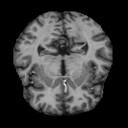

In [6]:
PIL.Image.open(str(non_demented_img[0]))

In [7]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data, 
    batch_size=32, 
    image_size=(128, 128), 
    seed=123, 
    validation_split=0.2, 
    subset="training"
)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [8]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data, 
    batch_size=32, 
    image_size=(128, 128), 
    seed=123, 
    validation_split=0.2, 
    subset="validation"
)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [9]:
class_names = training_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


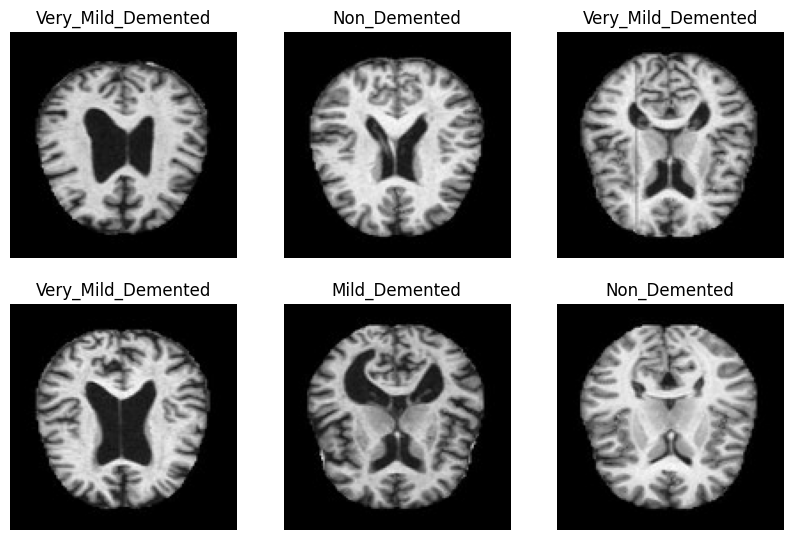

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
     


In [11]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.9,1.1),
        fill_mode='nearest')

In [12]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(128,128,3),
     pooling='avg',
    classes=4,
    weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(4, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 4)                2052      
 pper)                                                           
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
____________________________________

In [14]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
initial_learning_rate = 0.08
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [15]:
resnet_model.compile(optimizer=Adam(lr=0.09),loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

In [16]:
epochs=12
history = resnet_model.fit(
  training_ds,
  validation_data=testing_ds,
  epochs=epochs
)

Epoch 1/12
160/160 [==============================] - 17s 46ms/step - loss: 1.1784 - accuracy: 0.5365 - val_loss: 0.8715 - val_accuracy: 0.5969
Epoch 2/12
160/160 [==============================] - 5s 31ms/step - loss: 0.8721 - accuracy: 0.5971 - val_loss: 0.8207 - val_accuracy: 0.6094
Epoch 3/12
160/160 [==============================] - 5s 31ms/step - loss: 0.7935 - accuracy: 0.6463 - val_loss: 0.8756 - val_accuracy: 0.5984
Epoch 4/12
160/160 [==============================] - 5s 31ms/step - loss: 0.7577 - accuracy: 0.6543 - val_loss: 0.7729 - val_accuracy: 0.6469
Epoch 5/12
160/160 [==============================] - 5s 31ms/step - loss: 0.7205 - accuracy: 0.6783 - val_loss: 0.7653 - val_accuracy: 0.6477
Epoch 6/12
160/160 [==============================] - 5s 31ms/step - loss: 0.6709 - accuracy: 0.6980 - val_loss: 0.7480 - val_accuracy: 0.6570
Epoch 7/12
160/160 [==============================] - 5s 31ms/step - loss: 0.6655 - accuracy: 0.7010 - val_loss: 0.6999 - val_accuracy: 0.693

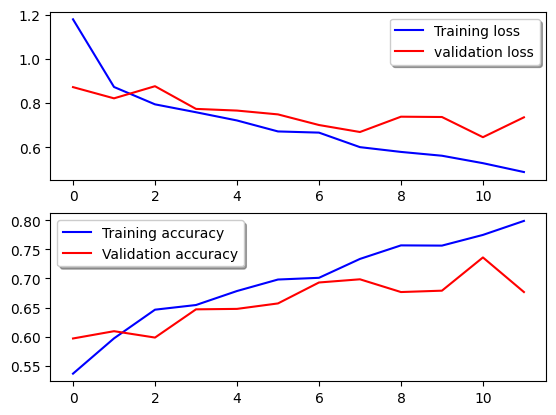

In [17]:
import matplotlib.pyplot as plt
# Plotting the results on Graph
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)